# <center>Comparison of performance of KNN algorithm and linear regression - case of violent crimes committed in different communities within the United States.</center>

***

<center>Final project for Machine Learning course</center>
<center><b>Ewelina Osowska, Ewa Sobolewska</b></center>

*****

### Table of contents:

* [Dataset description](#dataset-description)
* [Data Preprocessing](#data-preprocessing)
* [Feature selection](#feature-selection)
* [Modelling](#modelling)
    * [Linear regression](#linear-regression)
    * [KNN regression](#knn-regression)
* [Validation and assessment](#validation-and-assessment)
* [Conclusions](#conclusions)

In [1]:
%autosave 0

Autosave disabled


In [2]:
# Loading libraries
import pandas as pd
import warnings
from scipy import stats
from sklearn import feature_selection
import seaborn as sns
import matplotlib.pyplot as plt

# General settings
pd.set_option("display.max_columns",130)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dataset description <a class="anchor" id="dataset-description"></a>

The dataset used in ...

Many variables are included so that algorithms that select or learn weights for attributes could be tested. However, clearly unrelated attributes were not included; attributes were picked if there was any plausible connection to crime (N=122), plus the attribute to be predicted (Per Capita Violent Crimes). The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units. 

The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in incorrect values for per capita violent crime. These cities are not included in the dataset. Many of these omitted communities were from the midwestern USA. 

Data is described below based on original values. All numeric data was normalized into the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. Attributes retain their distribution and skew (hence for example the population attribute has a mean value of 0.06 because most communities are small). E.g. An attribute described as 'mean people per household' is actually the normalized (0-1) version of that value. 

The normalization preserves rough ratios of values WITHIN an attribute (e.g. double the value for double the population within the available precision - except for extreme values (all values more than 3 SD above the mean are normalized to 1.00; all values more than 3 SD below the mean are nromalized to 0.00)). 

However, the normalization does not preserve relationships between values BETWEEN attributes (e.g. it would not be meaningful to compare the value for whitePerCap with the value for blackPerCap for a community) 

A limitation was that the LEMAS survey was of the police departments with at least 100 officers, plus a random sample of smaller departments. For our purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data. 




The Law Enforcement Management and Administrative Statistics (LEMAS) survey collects data from a nationally representative sample of state, county, and local law enforcement agencies in the United States. For most questions, a reference date of June 30, 2016 was used.

The 2016 LEMAS sample design called for the survey questionnaire to be sent to 3,499 general purpose state and local law enforcement agencies. The design called for all agencies employing 100 or sworn personnel to be included with certainty (self-representing), and for smaller agencies to be sampled from strata based on number of sworn officers and type of agency.

A total of 27 local police departments were determined to be out-of-scope for the survey because they were special jurisdiction agencies, had closed, had outsourced their operations, or were operating on a part-time basis. The final mail out total of 3,472 agencies included 2,613 local police departments, 810 sheriffs' offices, and the 49 state agencies.

A total of 2,780 agencies responded to the LEMAS questionnaire, for a response rate of 80%. The final database includes responses from 2,136 local police departments, 600 sheriffs' offices, and 49 state law enforcement agencies (including partial responses from 5 primary state police agencies). The overall response rate for local police departments was 82%, 74% for sheriffs' offices, and 90% for state law enforcement agencies.

## Data preprocessing <a class="anchor" id="data-preprocessing"></a>

Before each step data is saved in reproducible form of a pickle. The data has 1994 observations and 128 columns. Each observation states for different communities. The steps necessary to get the pickle used below are attached in the supplement.

In [3]:
mydata = pd.read_pickle("dataset/mydata.p")

In [4]:
mydata.shape

(1994, 127)

In [5]:
mydata.head()

,state,county,community,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.

In the dataset there are multiple missing values. They can be divided into three categories. Columns _county_ and _community_ don't have id numbers assigned, however these are only informational values and it doesn't affect the modelling process. Thus these columns may be ommitted without further consequences. The second category are columns that have 1675 missing values. They come from the 1990 LEMAS survey (The Law Enforcement Management and Administrative Statistics) and were not provided originally. Thus the filling of the variables is about 16%, we decided to discard these features from the analysis. The last category is one missing value in _OtherPerCap_ column. There are too few missing values in the column and also there no other important missing values in the row, so we cannot omit it. Taken steps will be explained later on.

In [6]:
print(mydata.isnull().sum()[mydata.isnull().sum()>1])

county                  1174
community               1177
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


In [7]:
mydata = mydata.drop(["county", "community"], axis=1)

In [8]:
mydata = mydata.drop(mydata.columns[mydata.apply(lambda col: col.isnull().sum() > 1)], axis=1)

There are many missings inputation methods. As a first step, we checked the distribution of the variable. It seems that its values are aggregated between 0.17 (Q1) and 0.36 (Q3) overall and between 0.15 (Q1) and 0.315 (Q3) only in Mississippi - the state within which the missing value occurs. Thus we decided to fill the value with the median in this state.

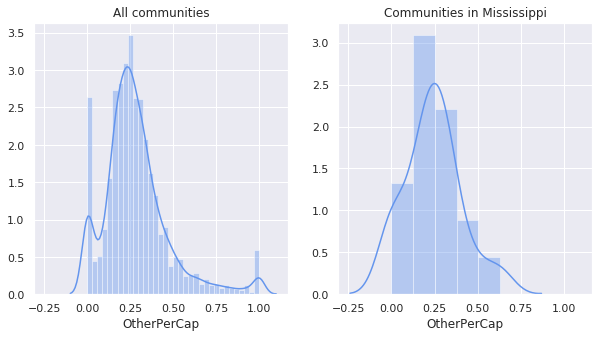

In [9]:
mydata_nonans = mydata.dropna()

sns.set()
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(mydata_nonans.OtherPerCap, color="cornflowerblue", ax=axes[0]).set_title("All communities")
sns.distplot(mydata_nonans[mydata_nonans.state==28].OtherPerCap, color="cornflowerblue", ax=axes[1]).set_title("Communities in Mississippi")
plt.show()

In [10]:
mydata[mydata.OtherPerCap.isna()]

,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
130,28,Natchezcity,0.02,0.38,0.98,0.22,0.01,0.01,0.44,0.4,0.27,0.58,0.0,0.0,0.09,0.24,0.35,0.31,0.65,0.78,0.49,0.12,0.18,0.32,0.15,0.08,0.37,NaN,0.63,0.05,0.85,0.54,0.54,0.29,0.86,0.19,0.31,0.53,0.37,0.51,0.62,0.44,0.62,0.65,0.49,0.2,0.2,0.13,0.19,0.59,0.5,0.04,0.85,0.0,0.22,0.16,0.13,0.11,0.01,0.0,0.0,0.0,0.98,0.02,0.28,0.24,0.4,0.36,0.47,0.52,0.17,0.46,0.5,0.05,0.52,0.55,0.31,0.68,0.38,0.51,0.55,0.06,0.06,0.08,0.0,0.06,0.11,0.11,0.6,0.44,0.76,0.0,0.0,0.01,0.84,0.7,0.83,0.77,0.04,0.12,0.05,0.0,0.23


In [11]:
mydata.OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.17
0.50    0.25
0.75    0.36
Name: OtherPerCap, dtype: float64

In [12]:
mydata[mydata.state==28].OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.1400
0.50    0.2300
0.75    0.3225
Name: OtherPerCap, dtype: float64

In [13]:
mydata.loc[130, "OtherPerCap"] = 0.23

In [14]:
mydata.to_pickle("dataset/mydata_step1.p")

## Feature selection <a class="anchor" id="feature-selection"></a>

In [20]:
mydata = pd.read_pickle("dataset/mydata_step1.p")

In [22]:
numCols = ['population', 'householdsize', 'racepctblack', 'racePctWhite', 
           'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 
           'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome',
           'pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst',
           'pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap',
           'indianPerCap','AsianPerCap','OtherPerCap', 'HispPerCap', 
           'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad',
           'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 
           'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf',
           'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 
           'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 
           'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg',
           'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10',
           'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 
           'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 
           'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 
           'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 
           'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc',
           'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 
           'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal',
           'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent',
           'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 
           'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState',
           'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LandArea', 
           'PopDens', 'PctUsePubTrans', 'LemasPctOfficDrugUn']
target_var = 'ViolentCrimesPerPop'

### Filter method - correlations

In [49]:
#what are the correlation coefficients between columns and target?
filterlist = []
for colname in numCols:
    pearson = stats.pearsonr(mydata[colname], mydata[target_var])
    spearman = stats.spearmanr(mydata[colname], mydata[target_var])
    print(colname)
    print(" \n Pearson: coeff={0:2.2f} p-value={1:1.3f} \n Spearman: coeff={2:2.2f} p-value={3:1.3f} \n".format(pearson[0], pearson[1], spearman.correlation, spearman.pvalue))
    filterlist.append([colname, pearson[0], pearson[1], spearman.correlation, spearman.pvalue])

population
 
 Pearson: coeff=0.37 p-value=0.000 
 Spearman: coeff=0.37 p-value=0.000 

householdsize
 
 Pearson: coeff=-0.03 p-value=0.119 
 Spearman: coeff=-0.12 p-value=0.000 

racepctblack
 
 Pearson: coeff=0.63 p-value=0.000 
 Spearman: coeff=0.60 p-value=0.000 

racePctWhite
 
 Pearson: coeff=-0.68 p-value=0.000 
 Spearman: coeff=-0.70 p-value=0.000 

racePctAsian
 
 Pearson: coeff=0.04 p-value=0.093 
 Spearman: coeff=-0.01 p-value=0.705 

racePctHisp
 
 Pearson: coeff=0.29 p-value=0.000 
 Spearman: coeff=0.32 p-value=0.000 

agePct12t21
 
 Pearson: coeff=0.06 p-value=0.007 
 Spearman: coeff=0.17 p-value=0.000 

agePct12t29
 
 Pearson: coeff=0.15 p-value=0.000 
 Spearman: coeff=0.31 p-value=0.000 

agePct16t24
 
 Pearson: coeff=0.10 p-value=0.000 
 Spearman: coeff=0.32 p-value=0.000 

agePct65up
 
 Pearson: coeff=0.07 p-value=0.003 
 Spearman: coeff=0.07 p-value=0.002 

numbUrban
 
 Pearson: coeff=0.36 p-value=0.000 
 Spearman: coeff=0.27 p-value=0.000 

pctUrban
 
 Pearson: coeff

In [65]:
#converting to dataframe
filterdf = pd.DataFrame(filterlist, columns=('name', 'pearson_coef', 'pearson_pval', 'spearman_coef', 'spearman_pval'))
#changing index to colnames and deleting name column
filterdf.index = filterdf.name
filterdf = filterdf.drop('name', axis=1)

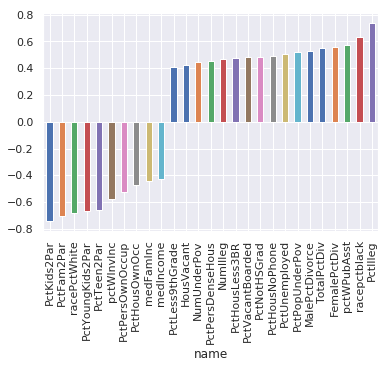

In [80]:
# which columns have the highest correlation - plot?
cutoff = 0.4
filterdf.pearson_coef[filterdf.pearson_coef.abs()>cutoff].sort_values().plot.bar()

In [79]:
# which columns have the highest correlation - enumerated?
filterdf.pearson_coef[filterdf.pearson_coef.abs()>cutoff].sort_values()

name
PctKids2Par        -0.738424
PctFam2Par         -0.706667
racePctWhite       -0.684770
PctYoungKids2Par   -0.666059
PctTeen2Par        -0.661582
pctWInvInc         -0.576324
PctPersOwnOccup    -0.525491
PctHousOwnOcc      -0.470683
medFamInc          -0.439108
medIncome          -0.424221
PctLess9thGrade     0.411096
HousVacant          0.421396
NumUnderPov         0.447582
PctPersDenseHous    0.452901
NumIlleg            0.471028
PctHousLess3BR      0.474490
PctVacantBoarded    0.482816
PctNotHSGrad        0.483366
PctHousNoPhone      0.488243
PctUnemployed       0.504235
PctPopUnderPov      0.521877
MalePctDivorce      0.525407
TotalPctDiv         0.552777
FemalePctDiv        0.556032
pctWPubAsst         0.574665
racepctblack        0.631264
PctIlleg            0.737957
Name: pearson_coef, dtype: float64

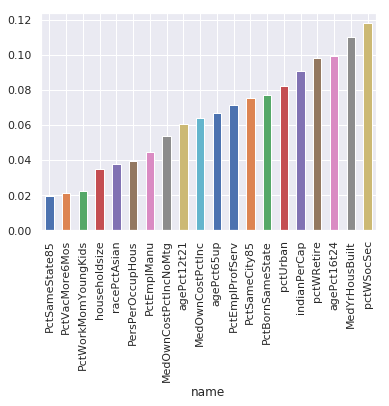

In [86]:
# which columns have the highest correlation - plot, absolute values?
cutoffno = 20
filterdf.pearson_coef.abs().sort_values().head(cutoffno).plot.bar()

In [87]:
# which columns have the highest correlation - enumerated, absolute values?
filterdf.pearson_coef.abs().sort_values().head(cutoffno)

name
PctSameState85           0.019459
PctVacMore6Mos           0.021283
PctWorkMomYoungKids      0.022535
householdsize            0.034923
racePctAsian             0.037622
PersPerOccupHous         0.039739
PctEmplManu              0.044906
MedOwnCostPctIncNoMtg    0.053763
agePct12t21              0.060477
MedOwnCostPctInc         0.063847
agePct65up               0.067171
PctEmplProfServ          0.071483
PctSameCity85            0.075558
PctBornSameState         0.077159
pctUrban                 0.082025
indianPerCap             0.090854
pctWRetire               0.098442
agePct16t24              0.099347
MedYrHousBuilt           0.109994
pctWSocSec               0.117977
Name: pearson_coef, dtype: float64

### Filter method - mutual info

In [96]:
minfos=[]
for var in numCols:
    print(var, " Mutual info", feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1),mydata["ViolentCrimesPerPop"].astype(float).values)[0])
    minfos.append(feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1),mydata["ViolentCrimesPerPop"].astype(float).values)[0])

population  Mutual info 0.1234721534380534
householdsize  Mutual info 0.05792967752813727
racepctblack  Mutual info 0.2532353600493029
racePctWhite  Mutual info 0.34841870833256827
racePctAsian  Mutual info 0
racePctHisp  Mutual info 0.14086140749061915
agePct12t21  Mutual info 0.02680975581549383
agePct12t29  Mutual info 0.09304957327446406
agePct16t24  Mutual info 0.11666921641040506
agePct65up  Mutual info 0.04047460516502177
numbUrban  Mutual info 0.13719057654921896
pctUrban  Mutual info 0.02097959743847344
medIncome  Mutual info 0.1604790312702269
pctWWage  Mutual info 0.0404775211743047
pctWFarmSelf  Mutual info 0.027336947151551882
pctWInvInc  Mutual info 0.29091681591857643
pctWSocSec  Mutual info 0.031526369491031936
pctWPubAsst  Mutual info 0.26911230324684077
pctWRetire  Mutual info 0.03199680714688036
medFamInc  Mutual info 0.20104732009613802
perCapInc  Mutual info 0.12774257857142768
whitePerCap  Mutual info 0.05754077738881236
blackPerCap  Mutual info 0.1391983358574577

In [107]:
imp = list(zip(minfos, numCols))
imp.sort(reverse=True)
imp = pd.DataFrame(imp, columns=['MI', 'name'])
imp.head(20)

,MI,name
0,0.469052,PctKids2Par
1,0.427291,PctIlleg
2,0.365249,PctFam2Par
3,0.335731,PctTeen2Par
4,0.326069,racePctWhite
5,0.323048,NumIlleg
6,0.317594,PctYoungKids2Par
7,0.286476,pctWInvInc
8,0.283684,PctPopUnderPov
9,0.282839,NumUnderPov


### Forward/reverse selection

In [ ]:
#nie wiem czy tutaj damy kod czy jest jakiś sposób na szybkie zrobienie tego
# czy mam pętle pisać...
# nie ogarniam kiedy robi się backward kiedy forward czy to wybierasz?

## Modelling <a class="anchor" id="modelling"></a>

### Linear regression <a class="anchor" id="linear-regression"></a>

### KNN regression <a class="anchor" id="knn-regression"></a>

## Validation and assessment <a class="anchor" id="validation-and-assessment"></a>

## Conclusions <a class="anchor" id="conclusions"></a>